In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, RepeatVector, TimeDistributed, LSTM

# used to unzip weather data from Keras
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import root_mean_squared_error as rmse



# Problem Description

The dataset I chose for my final project includes weather data from Jan 10, 2009 - December 31, 2016 from a weather station in Jena, Germany. The data is reported every 10 minutes between that 7-year period. Weather data includes columns such as humidity, temperature, vapor pressure, and wind speed.

The goal of my final project is to leverage RNNs to forecast the temperature in 2016 by training on the weather data before 2016.

# Download Dataset from Keras

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

### Rename Columns so they're more Intuitive

In [3]:
col_names = list(df.columns)
col_names

new_col_names = ["Timestamp", "Pressure", "Temperature (C)", "Temperature (Kelvin)", "Temperature (dew point)", "Relative Humidity",
          "Saturation vapor pressure", "Vapor pressure", "Vapor pressure deficit", "Specific humidity",
          "Water vapor concentration", "Airtight", "Wind speed", "Maximum wind speed", "Wind direction (degrees)"]
metrics = new_col_names[1:]

# create dictionary with the keys col_list and new_col_names the values
col_convert = dict(zip(col_names, new_col_names))
col_convert

df = df.rename(columns=col_convert)
df.head()


Timestamp  Pressure  Temperature (C)  Temperature (Kelvin)  \
0  01.01.2009 00:10:00    996.52            -8.02                265.40   
1  01.01.2009 00:20:00    996.57            -8.41                265.01   
2  01.01.2009 00:30:00    996.53            -8.51                264.91   
3  01.01.2009 00:40:00    996.51            -8.31                265.12   
4  01.01.2009 00:50:00    996.51            -8.27                265.15   

   Temperature (dew point)  Relative Humidity  Saturation vapor pressure  \
0                    -8.90               93.3                       3.33   
1                    -9.28               93.4                       3.23   
2                    -9.31               93.9                       3.21   
3                    -9.07               94.2                       3.26   
4                    -9.04               94.1                       3.27   

   Vapor pressure  Vapor pressure deficit  Specific humidity  \
0            3.11                    0.22               1.94   
1            3.02                    0.21               1.89   
2            3.01                    0.20               1.88   
3            3.07                    0.19               1.92   
4            3.08                    0.19               1.92   

   Water vapor concentration  Airtight  Wind speed  Maximum wind speed  \
0                       3.12   1307.75        1.03                1.75   
1                       3.03   1309.80        0.72                1.50   
2                       3.02   1310.24        0.19                0.63   
3                       3.08   1309.19        0.34                0.50   
4                       3.09   1309.00        0.32                0.63   

   Wind direction (degrees)  
0                     152.3  
1                     136.1  
2                     171.6  
3                     198.0  
4                     214.3

### Check for NA Values

In [ ]:
df.isna().sum()

Timestamp                    0
Pressure                     0
Temperature (C)              0
Temperature (Kelvin)         0
Temperature (dew point)      0
Relative Humidity            0
Saturation vapor pressure    0
Vapor pressure               0
Vapor pressure deficit       0
Specific humidity            0
Water vapor concentration    0
Airtight                     0
Wind speed                   0
Maximum wind speed           0
Wind direction (degrees)     0
dtype: int64

### Get a summary of the columns

In [ ]:
df.describe()

Timestamp       Pressure  Temperature (C)  \
count                         420531  420531.000000    420531.000000   
mean   2012-12-30 03:57:42.834845184     989.212729         9.449734   
min              2009-01-01 00:10:00     913.600000       -23.010000   
25%              2010-12-31 02:35:00     984.200000         3.360000   
50%              2012-12-30 04:40:00     989.580000         9.410000   
75%              2014-12-29 16:25:00     994.720000        15.470000   
max              2017-01-01 00:00:00    1015.350000        37.280000   
std                              NaN       8.358677         8.423351   

       Temperature (Kelvin)  Temperature (dew point)  Relative Humidity  \
count         420531.000000            420531.000000      420531.000000   
mean              76.008531                13.575903           9.533513   
min               12.950000                 0.950000           0.790000   
25%               65.210000                 7.780000           6.210000   
50%               79.300000                11.820000           8.860000   
75%               89.400000                17.600000          12.350000   
max              100.000000                63.770000          28.320000   
std               16.476500                 7.739038           4.184115   

       Saturation vapor pressure  Vapor pressure  Vapor pressure deficit  \
count              420531.000000   420531.000000            420531.00000   
mean                    4.042308     1216.064581                 2.13021   
min                     0.000000     1059.450000                 0.00000   
25%                     0.870000     1187.490000                 0.99000   
50%                     2.190000     1213.790000                 1.76000   
75%                     5.300000     1242.770000                 2.86000   
max                    46.010000     1393.540000                14.63000   
std                     4.896939       39.975272                 1.54176   

       Specific humidity  
count      420531.000000  
mean          174.735147  
min             0.000000  
25%           124.900000  
50%           198.100000  
75%           234.100000  
max           360.000000  
std            86.674735

Maximum wind speed and wind speed should not have negative values so let's remove those

In [4]:
df = df.loc[(df["Wind speed"] >= 0) & (df["Maximum wind speed"] >= 0)]


In [5]:
# convert dataframe to datetime and sort values by timestamp
df["Timestamp"] = df["Timestamp"].astype('datetime64[ns]')
df = df.sort_values(by=["Timestamp"])


Process the date column for train and test including:
* Convert date column to timestamp and rename it to timestamp
* Create date, year, month, and week columns from timestamp used primarily for EDA
* Sort values by timestamp

In [6]:
def process_timestamp(df):
  df["Date"] = df["Timestamp"].dt.date
  df['Year'] = df["Timestamp"].dt.year
  df['Month'] = df["Timestamp"].dt.month
  # df['week'] = df["timestamp"].dt.isocalendar().week
  df['Weekday'] = df['Timestamp'].dt.strftime('%a')
  df['Week'] = df['Timestamp'].dt.isocalendar().week
  df['Hour'] = df['Timestamp'].dt.hour
  return df


# EDA

Create dataframes for plotting

In [ ]:
plot_df = process_timestamp(df)
train_plot_df = plot_df.loc[plot_df["Timestamp"] < dt(2016,1,1)]
test_plot_df = plot_df.loc[plot_df["Timestamp"] >= dt(2016,1,1)]



# Plot predictors over time

Pressure


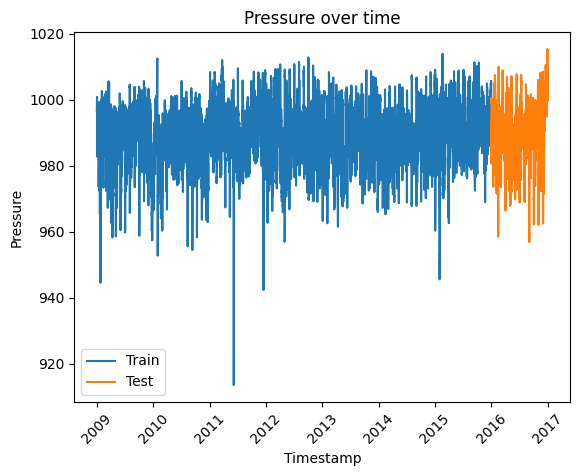

Temperature (C)


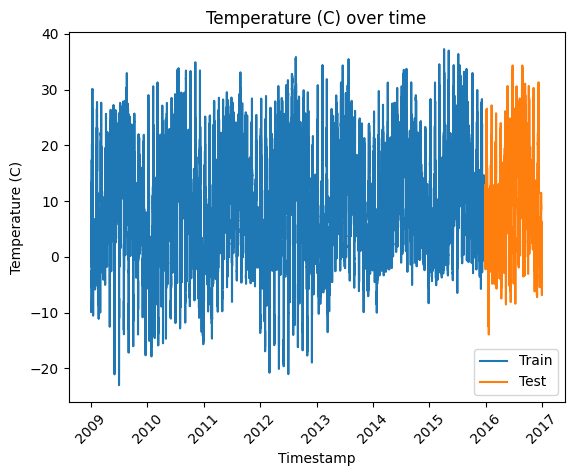

Temperature (Kelvin)


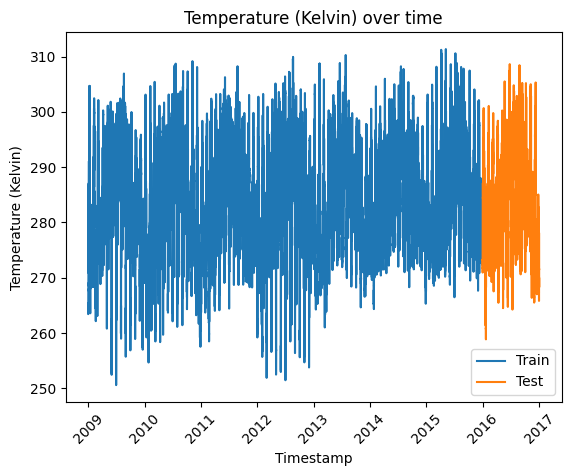

Temperature (dew point)


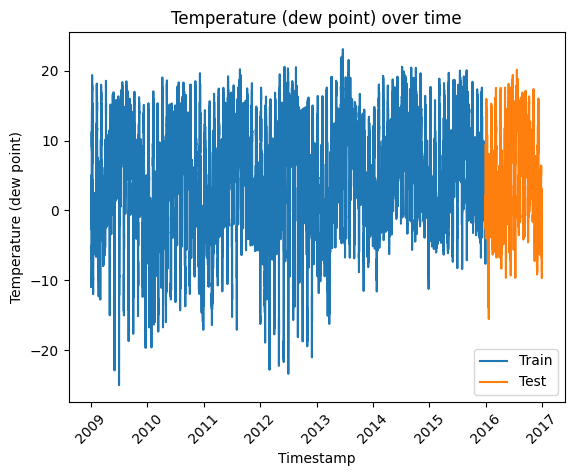

Relative Humidity


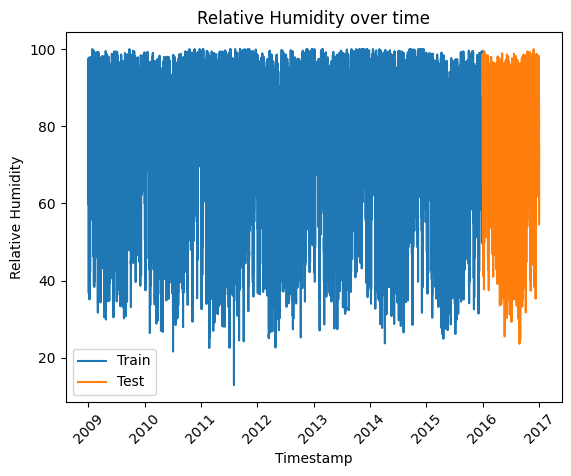

Saturation vapor pressure


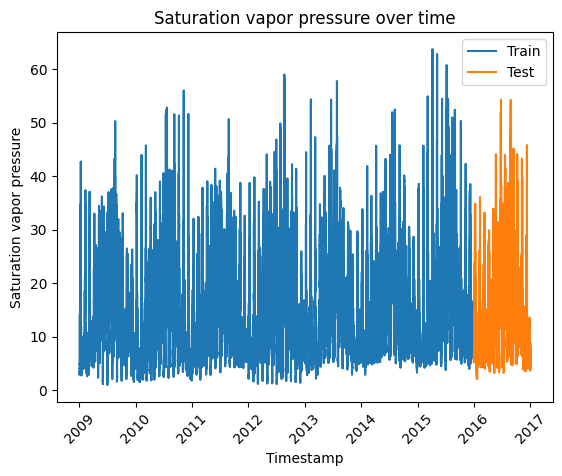

Vapor pressure


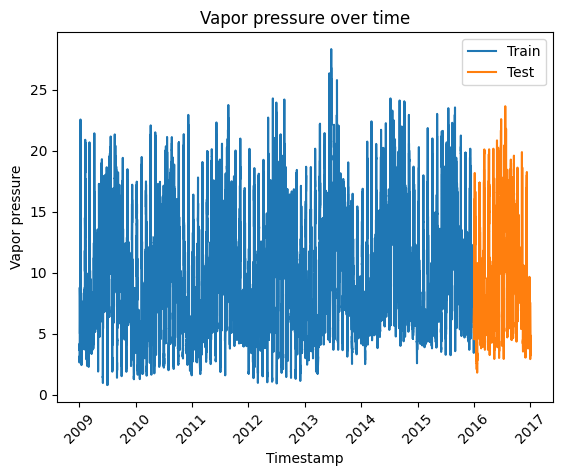

Vapor pressure deficit


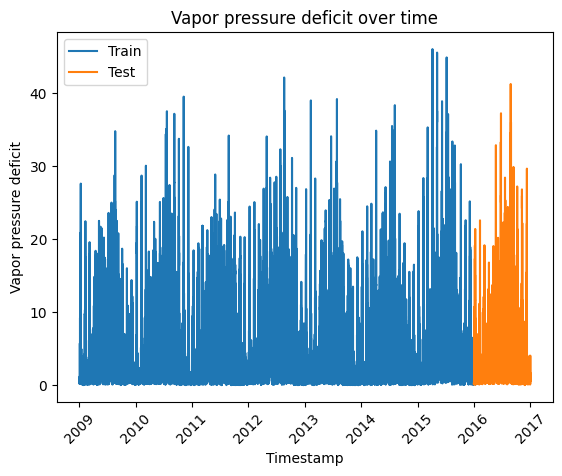

Specific humidity


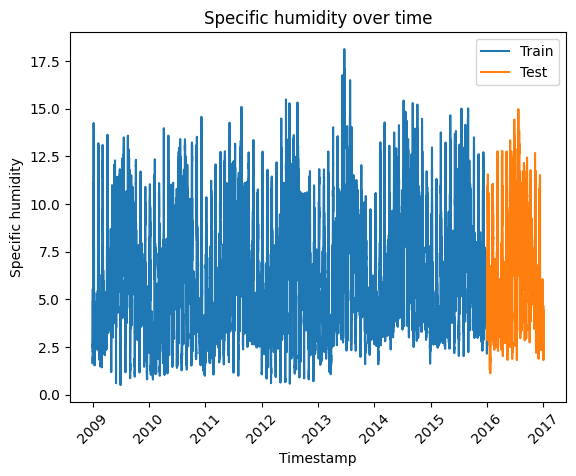

Water vapor concentration


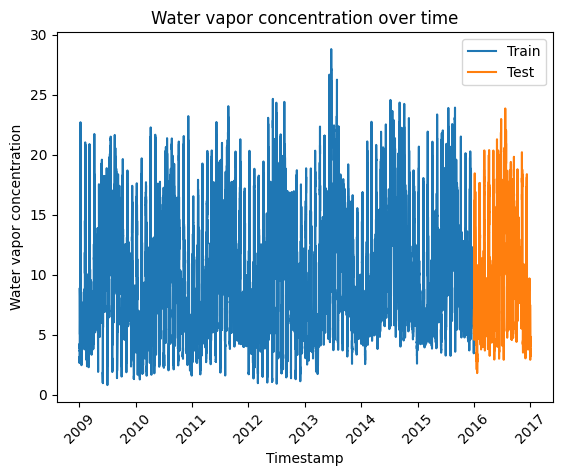

Airtight


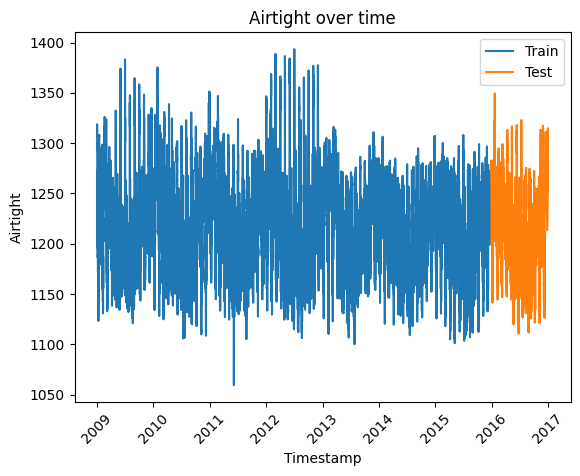

Wind speed


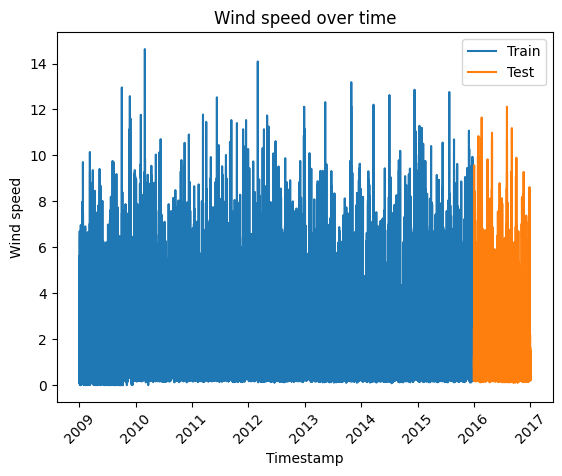

Maximum wind speed


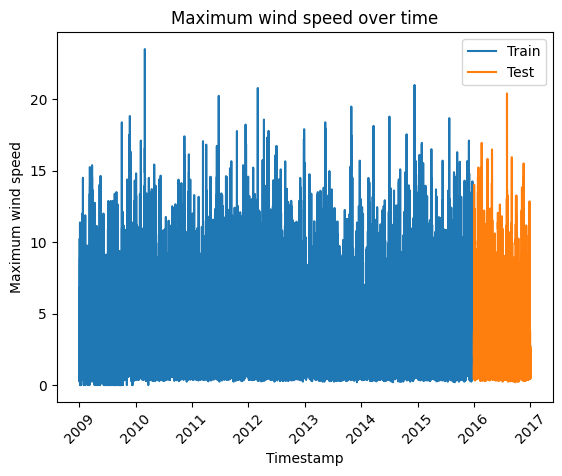

Wind direction (degrees)


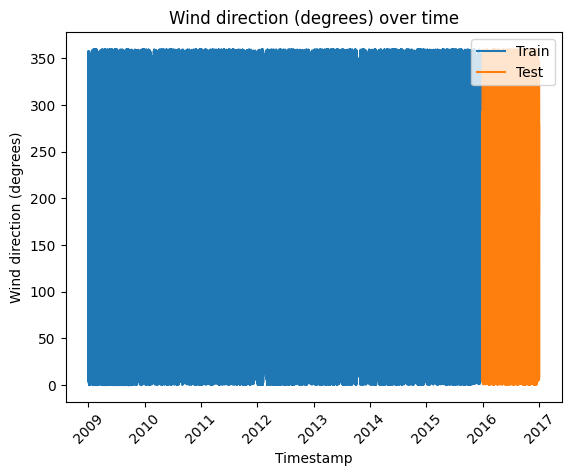

In [ ]:
for col in train_plot_df.columns:
  if col in new_col_names and col!="Timestamp":
    print(col)
    plt.figure()
    plt.plot(train_plot_df["Timestamp"], train_plot_df[col], label = "Train")
    plt.plot(test_plot_df["Timestamp"], test_plot_df[col], label = "Test")
    plt.xlabel("Timestamp")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"{col} over time")
    plt.xticks(rotation = 45)
    plt.show()


All columns except for wind direction seem to follow seasonal decreases and increases, which makes sense. For example, we'd expect temperature in Germany to be higher during the summer months and colder during the winter months.

Given wind direction is in degrees, it makes some sense that it looks essentially random between 0-360 degrees based on the randomness of weather patterns.

## Monthly Seasonal Behavior

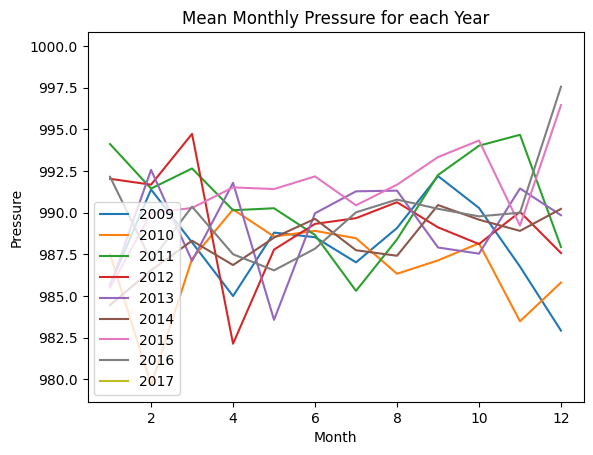

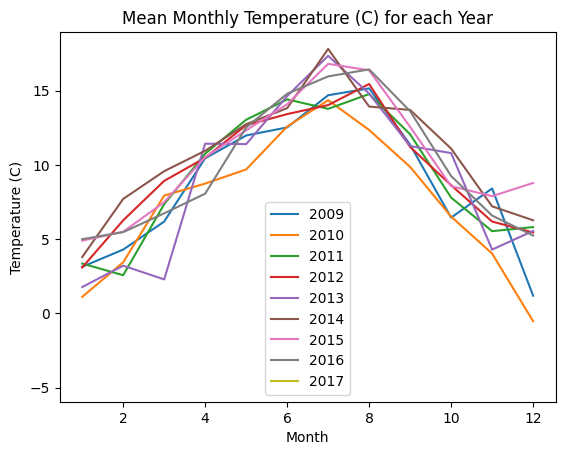

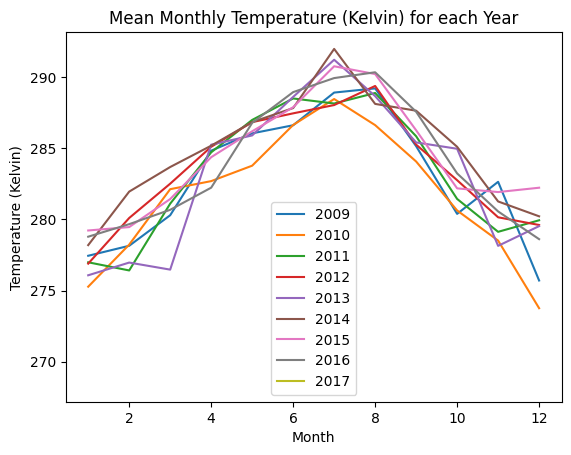

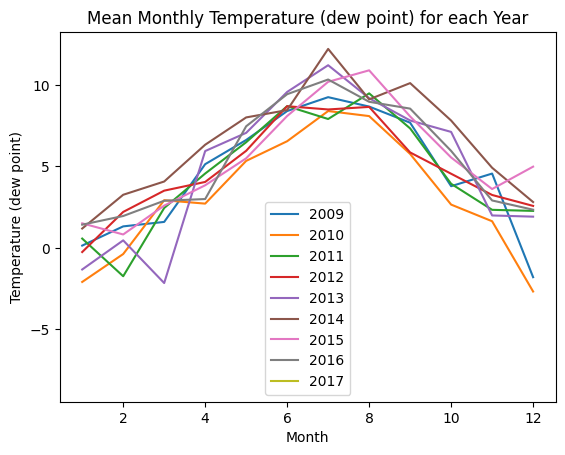

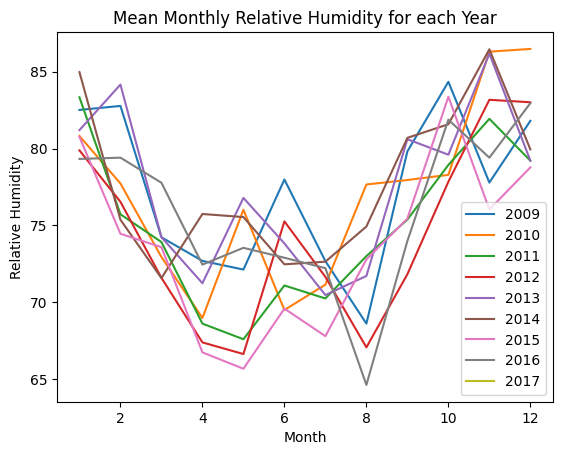

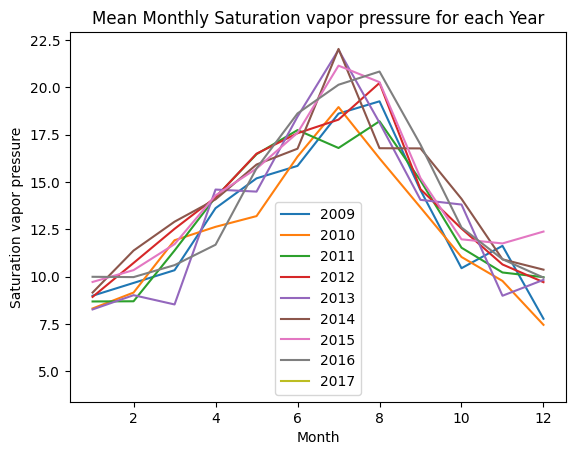

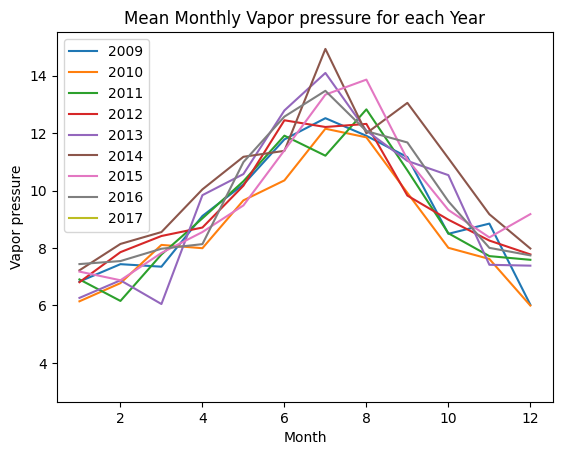

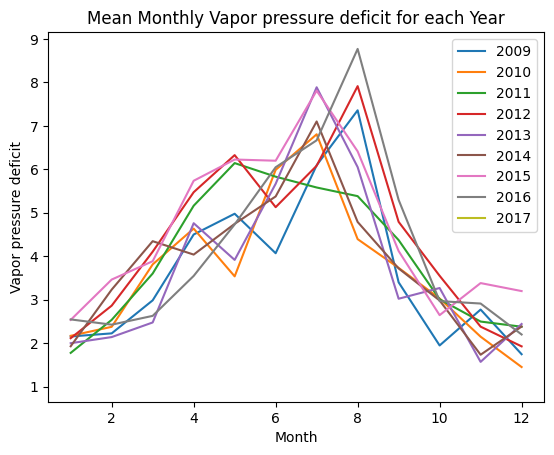

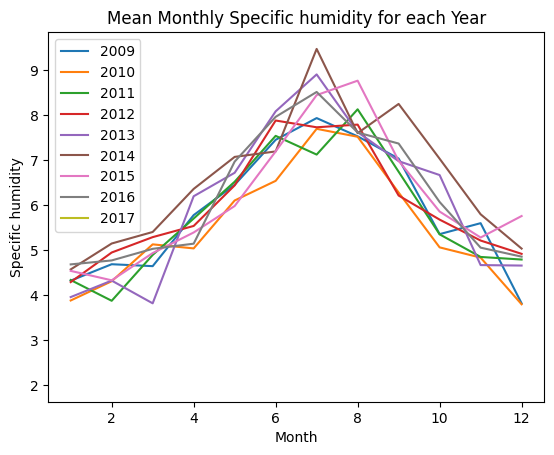

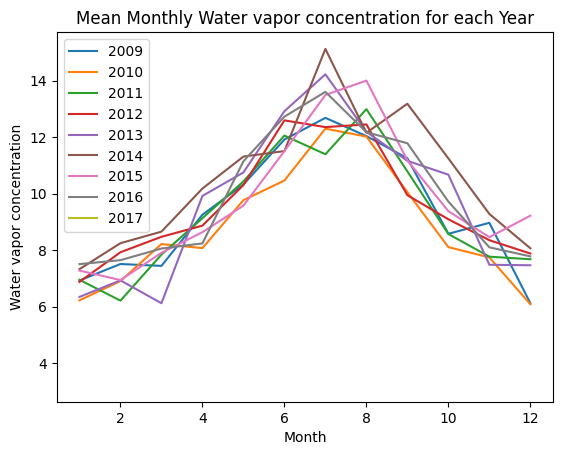

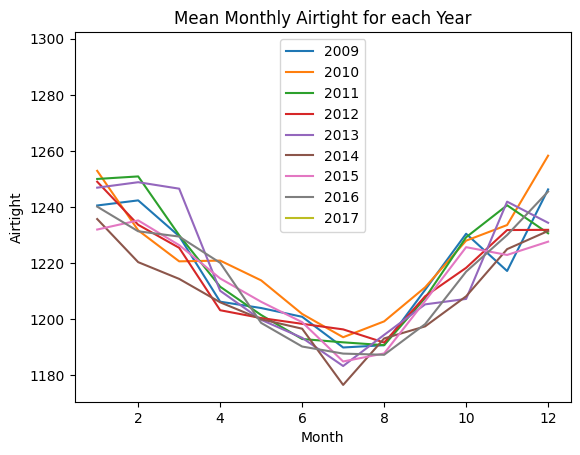

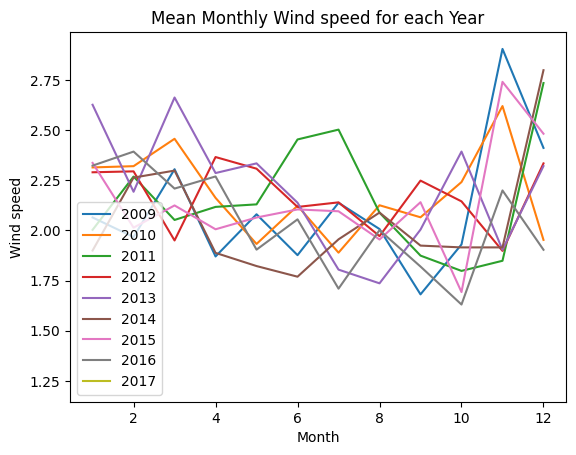

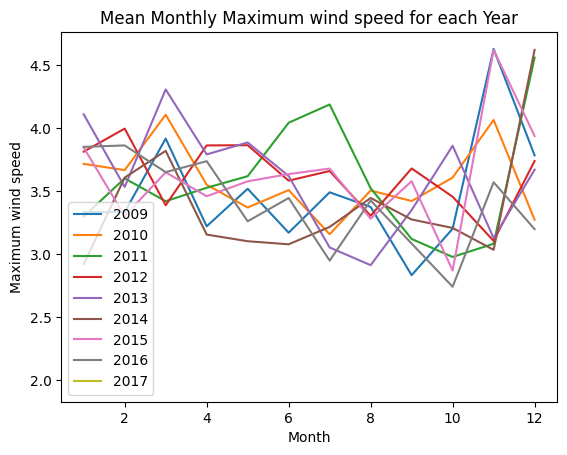

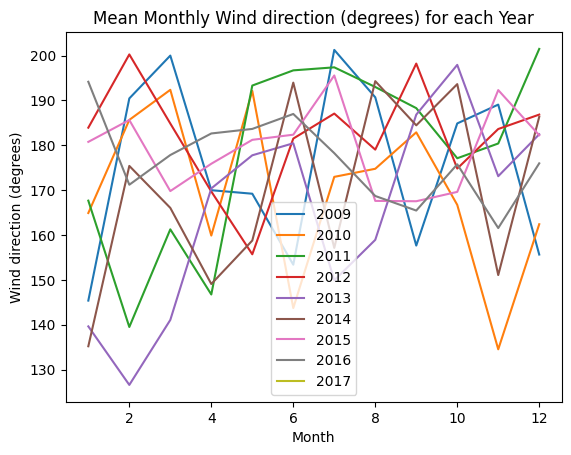

In [ ]:
monthly_plot_df = plot_df.groupby(["Year", "Month"], as_index=False)[metrics].mean()
for col in metrics:
  plt.figure()
  for i in monthly_plot_df["Year"].unique():
    year_df = monthly_plot_df.loc[monthly_plot_df["Year"] == i]
    plt.plot(year_df["Month"], year_df[col], label = i)
  plt.xlabel("Month")
  plt.ylabel(f"{col}")
  plt.legend()
  plt.title(f"Mean Monthly {col} for each Year")
  plt.show()


Monthly seasonal behavior seems to allude to the fact that for most weather behavior, there is a noticeable difference during summer and winter months. Columns such a temperature and vapor pressure increase during the summer months and drop off in winter while columns such as relative humidity drop in the summer months and climb during winter.

Another thing to notice is for the most part there isn't much variation across the years.

## Weekly Behavior

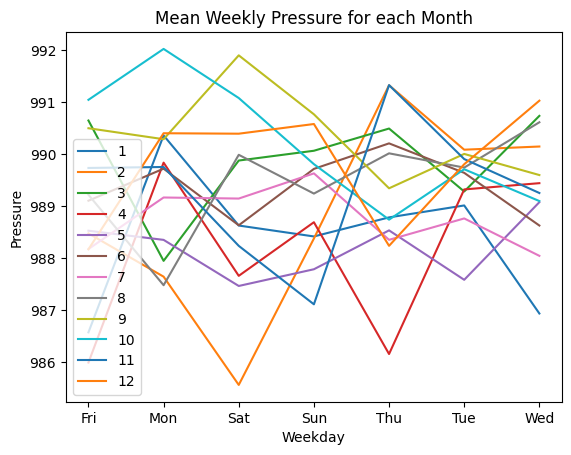

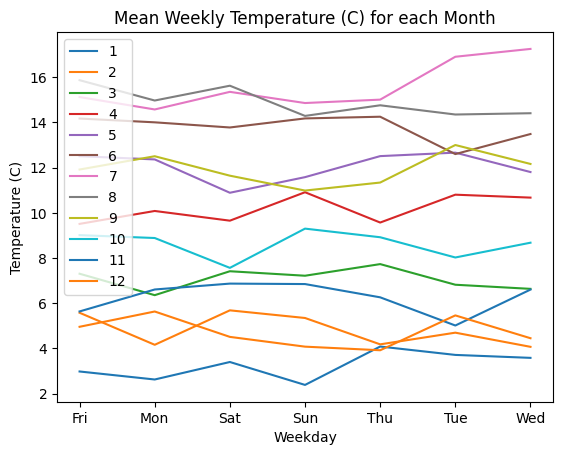

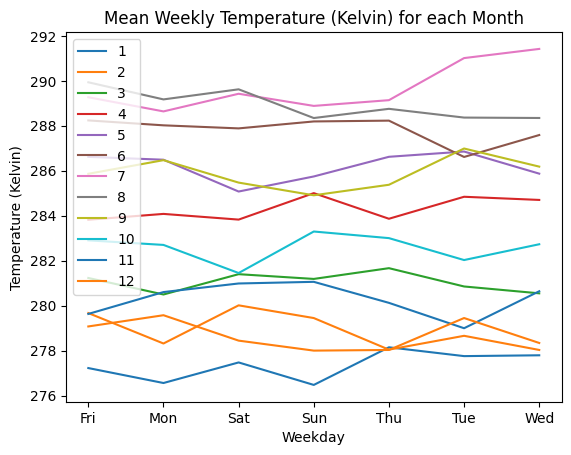

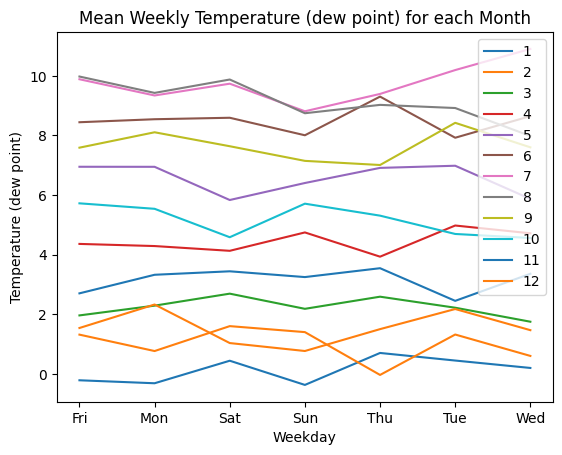

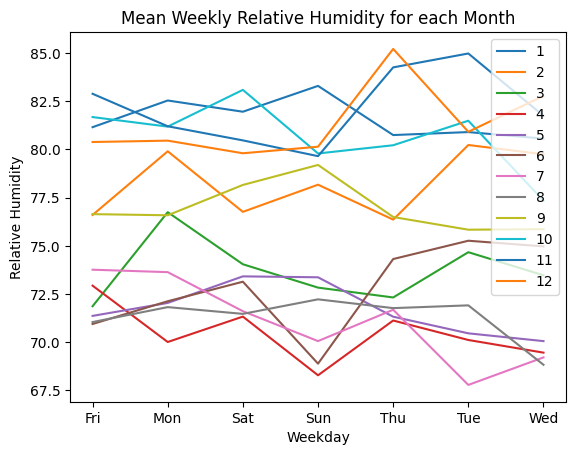

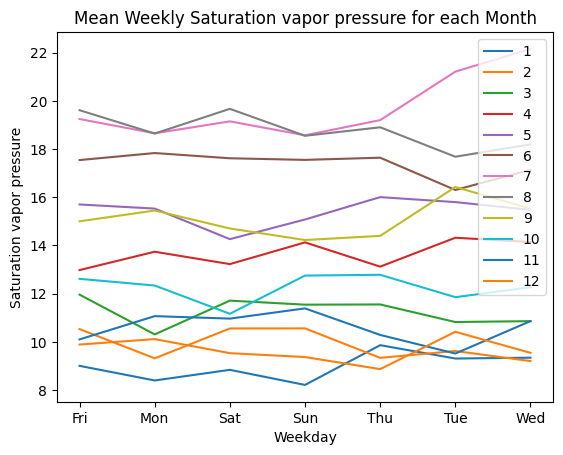

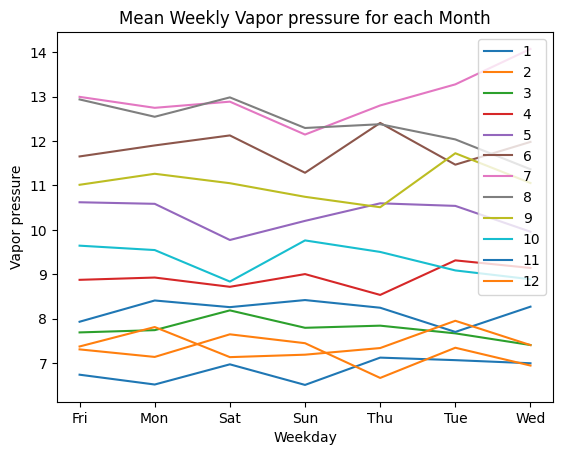

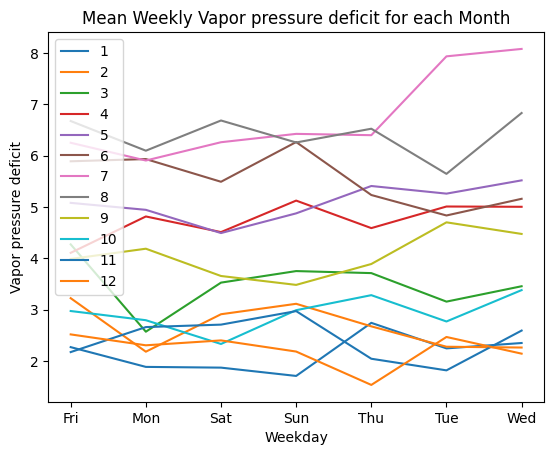

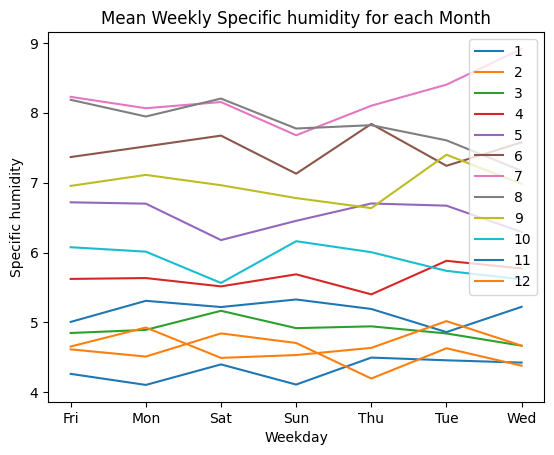

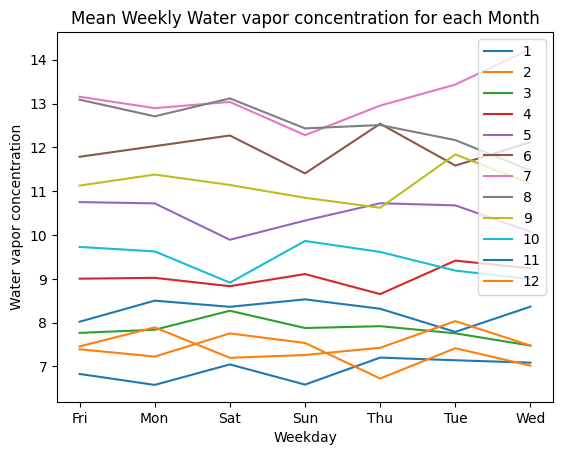

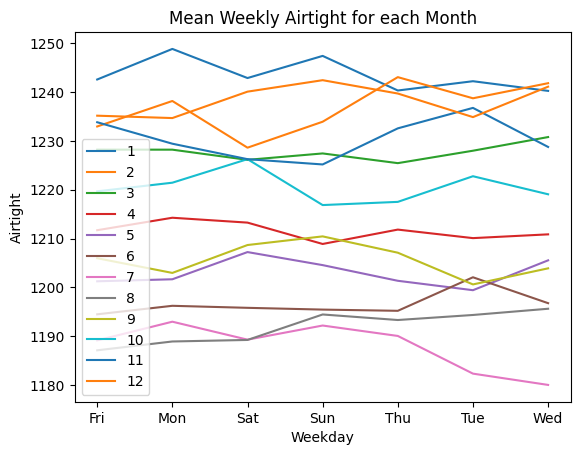

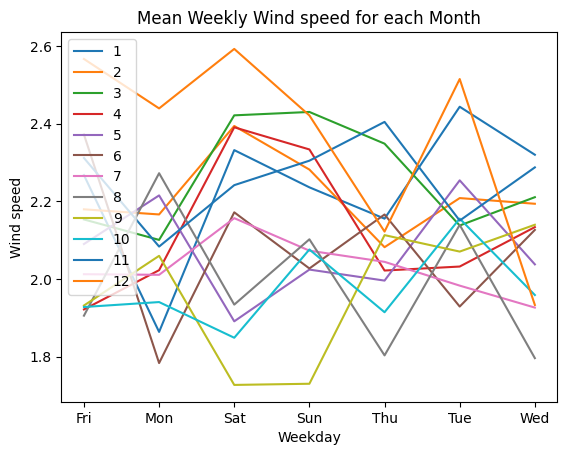

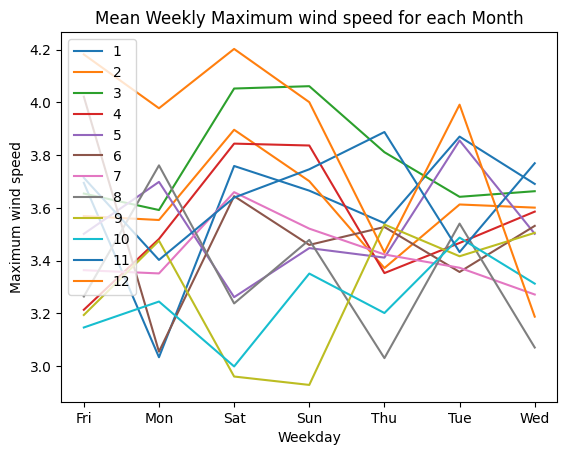

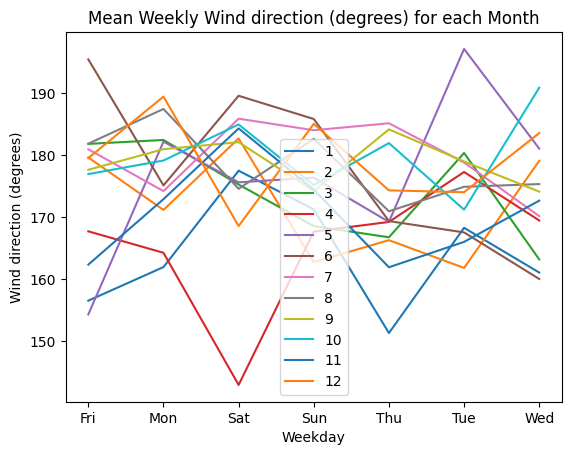

In [ ]:
weekly_plot_df = plot_df.groupby(["Month", "Weekday"], as_index=False)[metrics].mean()
for col in metrics:
  plt.figure()
  for i in weekly_plot_df["Month"].unique():
    year_df = weekly_plot_df.loc[weekly_plot_df["Month"] == i]
    plt.plot(year_df["Weekday"], year_df[col], label = i)
  plt.xlabel("Weekday")
  plt.ylabel(f"{col}")
  plt.legend()
  plt.title(f"Mean Weekly {col} for each Month")
  plt.show()


The weekly behavior above unlike the monthly behavior seems to provide little insight as there don't seem to be consistent changes in any metrics such as temperature,pressure, wind speed, and humidity over the course of a week (the wind looks almost random which makes sense).

This is intuitive given that weekdays don't show seasonal trends like the monthly view and weather patterns are likely driven more by seasonality than anything else.


## Daily Behavior

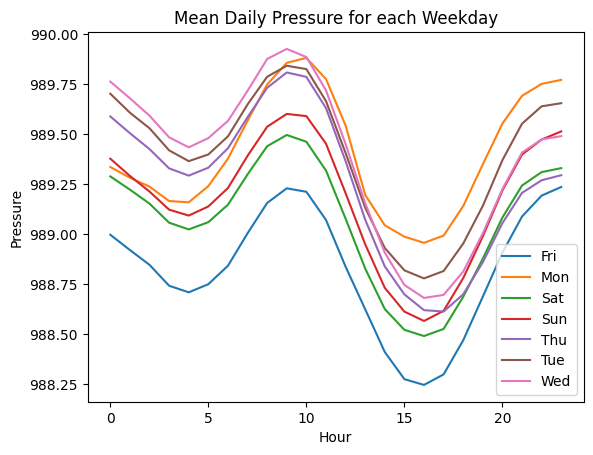

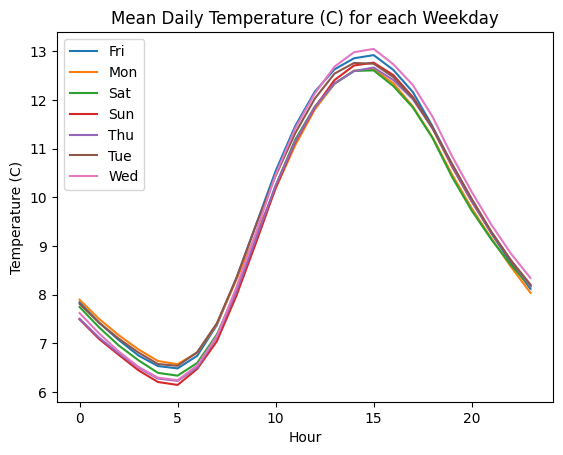

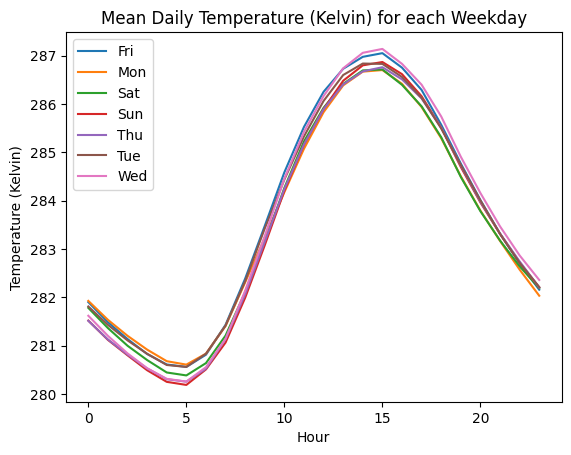

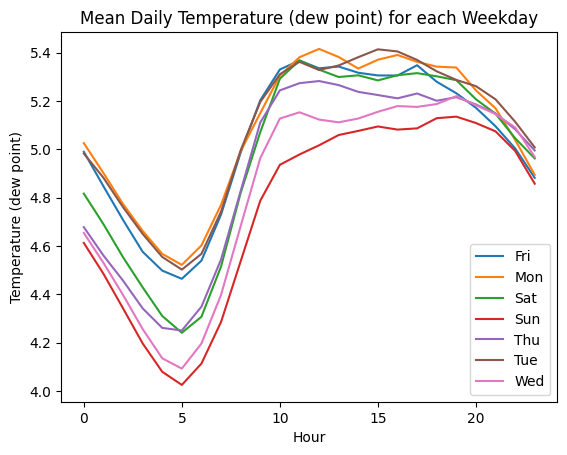

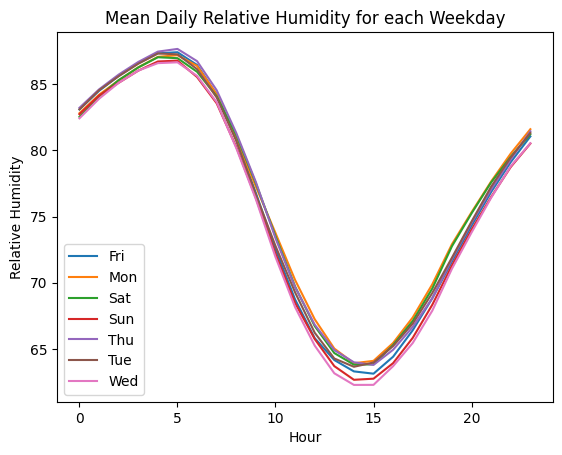

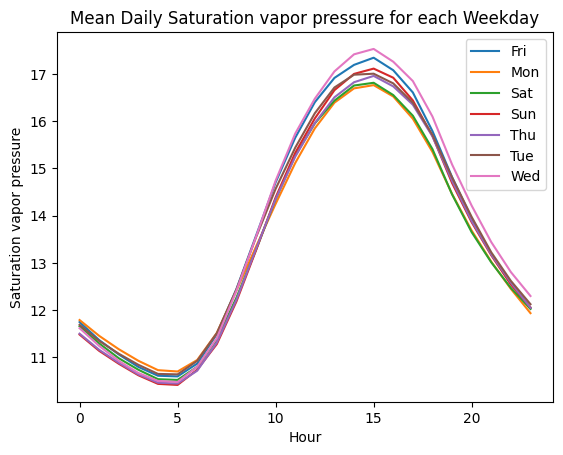

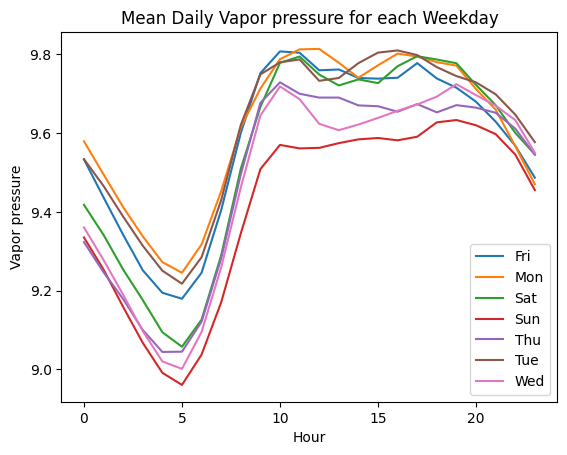

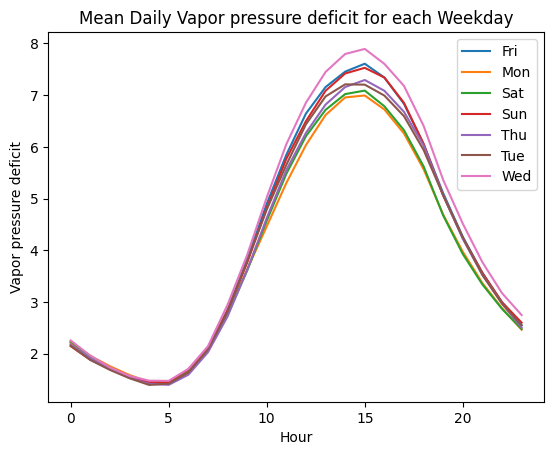

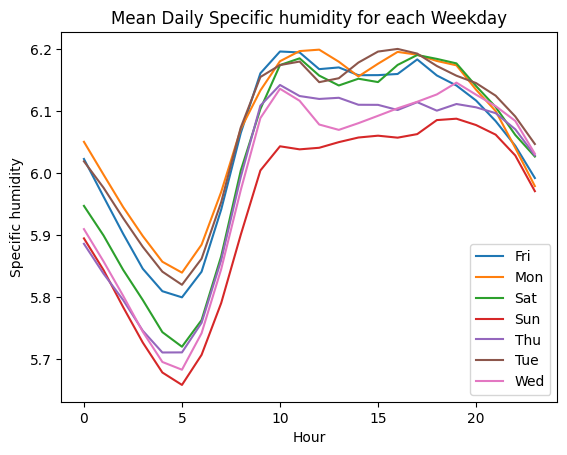

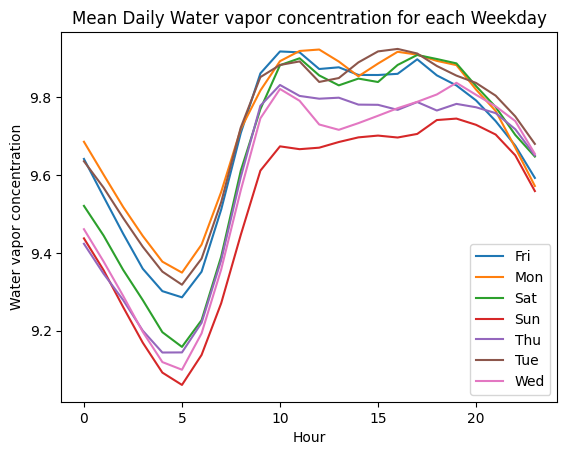

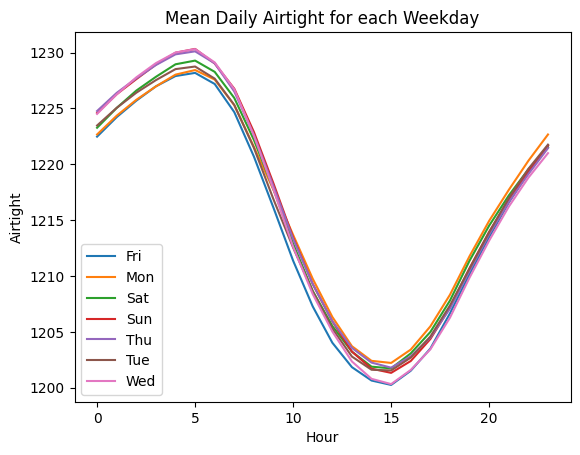

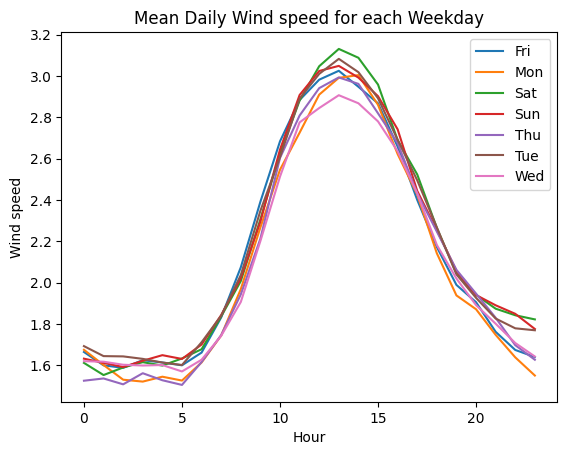

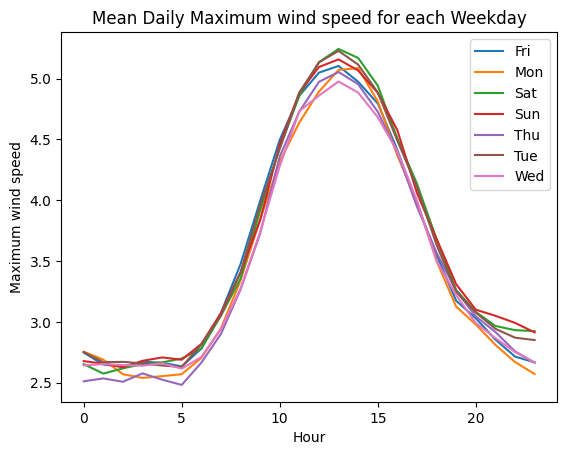

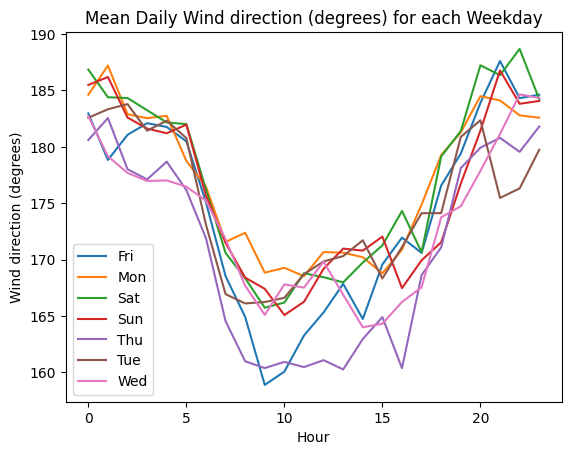

In [ ]:
daily_plot_df = plot_df.groupby(["Weekday", "Hour"], as_index=False)[metrics].mean()
for col in metrics:
  plt.figure()
  for i in daily_plot_df["Weekday"].unique():
    year_df = daily_plot_df.loc[daily_plot_df["Weekday"] == i]
    plt.plot(year_df["Hour"], year_df[col], label = i)
  plt.xlabel("Hour")
  plt.ylabel(f"{col}")
  plt.legend()
  plt.title(f"Mean Daily {col} for each Weekday")
  plt.show()


Similar to the winter and summer months, it also makes sense that weather patterns shift depending on the time of day which is what we're observing above


## Correlation Matrix

In [ ]:
corr = df[metrics].corr()
corr.style.background_gradient(cmap='coolwarm')


There are some very highly correlated columns, so if two predictors have a correlation >0.9, we drop one of the two.

In [7]:
df = df.drop(columns=['Temperature (Kelvin)', 'Temperature (dew point)', 'Maximum wind speed', 'Specific humidity', 'Water vapor concentration', 'Saturation vapor pressure'])


# Post-EDA Data Processing

Based on the EDA above, we decide to keep week, month, day, and hour as predictors in our model but drop weekday and year since there isn't much variability across the weather metrics for different weekdays or years.

In [8]:
df = process_timestamp(df)
df = df.drop(columns=["Year", "Weekday"])
# convert date to integer between 1-365
df["Date"] = pd.to_datetime(df["Date"]).dt.dayofyear
df.head()


Timestamp  Pressure  Temperature (C)  Relative Humidity  \
0 2009-01-01 00:10:00    996.52            -8.02               93.3   
1 2009-01-01 00:20:00    996.57            -8.41               93.4   
2 2009-01-01 00:30:00    996.53            -8.51               93.9   
3 2009-01-01 00:40:00    996.51            -8.31               94.2   
4 2009-01-01 00:50:00    996.51            -8.27               94.1   

   Vapor pressure  Vapor pressure deficit  Airtight  Wind speed  \
0            3.11                    0.22   1307.75        1.03   
1            3.02                    0.21   1309.80        0.72   
2            3.01                    0.20   1310.24        0.19   
3            3.07                    0.19   1309.19        0.34   
4            3.08                    0.19   1309.00        0.32   

   Wind direction (degrees)  Date  Month  Week  Hour  
0                     152.3     1      1     1     0  
1                     136.1     1      1     1     0  
2                     171.6     1      1     1     0  
3                     198.0     1      1     1     0  
4                     214.3     1      1     1     0

Split data into two sets-
* One for modeling (<2016) and
* One for validation (>=2016)

The modeling dataframe is fed into the RNN with

In [9]:
model_df = df.loc[df["Timestamp"] < dt(2016,1,1)].drop(columns=["Timestamp"])
scaler = MinMaxScaler()
train_data = scaler.fit_transform(model_df)
train_data = pd.DataFrame(train_data, columns=model_df.columns)

valid_df = df.loc[df["Timestamp"] >= dt(2016,1,1)]
valid_dt_ts = valid_df["Timestamp"]
valid_df = valid_df.drop(columns=["Timestamp"])
val_data = scaler.transform(valid_df)
val_data = pd.DataFrame(val_data, columns=valid_df.columns)

# append train_data and val_data
data = pd.concat([train_data, val_data])


In [ ]:
train_data.head()

Pressure  Temperature (C)  Relative Humidity  Vapor pressure  \
0  0.826390         0.248632           0.923033        0.084272   
1  0.826889         0.242163           0.924182        0.081003   
2  0.826490         0.240504           0.929925        0.080639   
3  0.826291         0.243822           0.933372        0.082819   
4  0.826291         0.244485           0.932223        0.083182   

   Vapor pressure deficit  Airtight  Wind speed  Wind direction (degrees)  \
0                0.004782  0.743213    0.070403                  0.423056   
1                0.004564  0.749349    0.049214                  0.378056   
2                0.004347  0.750666    0.012987                  0.476667   
3                0.004130  0.747523    0.023240                  0.550000   
4                0.004130  0.746954    0.021873                  0.595278   

   Date  Month  Week  Hour  
0   0.0    0.0   0.0   0.0  
1   0.0    0.0   0.0   0.0  
2   0.0    0.0   0.0   0.0  
3   0.0    0.0   0.0   0.0  
4   0.0    0.0   0.0   0.0

In [ ]:
# Use the past year worth of data (total raw timesteps for input)
past_raw_timesteps = 720
# To predict the next 12 hours (total raw timesteps for output)
future_raw_timesteps = 72
# Sampling rate for input sequence (e.g., take every 6th observation for input)
sampling_step_rate = 6

# Effective sequence length in terms of sampled points for the input
input_sequence_length_sampled = int(past_raw_timesteps / sampling_step_rate)

# Determine number of features for input and output
num_input_features = train_data.drop(columns=["Temperature (C)"]).shape[1] # 11 features after dropping target
num_output_features = 1

# Function to create sequences for input (X) and output (Y) for sequence-to-sequence model
def create_sequences(data_df, input_len_sampled, output_len_raw, sampling_rate, input_feature_cols, output_feature_name):
    X = []
    Y = []

    # Data array for input features (excluding target)
    input_data_array = data_df[input_feature_cols].values
    # Data array for target feature
    output_data_array = data_df[[output_feature_name]].values

    for i in range(len(data_df) - past_raw_timesteps - future_raw_timesteps + 1):
        # Extract input sequence: sample 'input_len_sampled' points from 'past_raw_timesteps' window at 'sampling_rate'
        x_sequence = input_data_array[i : i + past_raw_timesteps : sampling_rate]
        # Extract target sequence: 'output_len_raw' points directly after the input window (not sampled)
        y_sequence = output_data_array[i + past_raw_timesteps : i + past_raw_timesteps + future_raw_timesteps]

        X.append(x_sequence)
        Y.append(y_sequence)
    return np.array(X), np.array(Y)

# Identify input feature columns
input_feature_columns = [col for col in train_data.columns if col != "Temperature (C)"]

# Generate training sequences
X_train_seq, Y_train_seq = create_sequences(
    train_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

batch_size = 256

# Create tf.data.Dataset for training
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_seq, Y_train_seq))
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_train:", X_train_seq.shape)
print("Target sequence shape for dataset_train:", Y_train_seq.shape)


Input sequence shape for dataset_train: (367480, 120, 11)
Target sequence shape for dataset_train: (367480, 72, 1)


In [37]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


# Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters

In [ ]:
batch_size = 256 # Keep this consistent with dataset creation
epochs = 100

In [41]:
model = Sequential()
# Input shape for GRU: (sampled_sequence_length, num_input_features)
model.add(GRU(units=50, activation='relu', input_shape=(input_sequence_length_sampled, num_input_features)))
# Repeats the last hidden state for the number of future raw timesteps to predict
model.add(RepeatVector(future_raw_timesteps))
# return_sequences=True for sequence output
model.add(GRU(units=50, activation='relu', return_sequences=True))
# Predicts one feature (Temperature C) for each output timestep
model.add(TimeDistributed(Dense(units=num_output_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 72, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 72, 1)          │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# Pass the pre-made validation dataset to validation_data argument instead of using validation_split
model.fit(dataset_train, epochs=epochs, callbacks=[es_callback], validation_data=dataset_val)

Epoch 1/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - loss: 0.0202 - val_loss: 0.0049
Epoch 2/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 4/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 5/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 6/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 7/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 8/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 11/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0034 - val_loss: 0.00

0.0029713676776736975


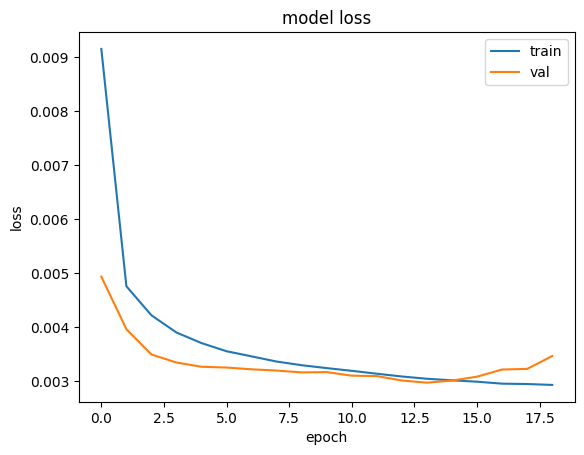

In [45]:
# plot validation loss vs loss
print(min(model.history.history['val_loss']))
plt.figure()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
model.save('/content/drive/MyDrive/Colab Notebooks/weather_gru_model_1.keras')

In [47]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


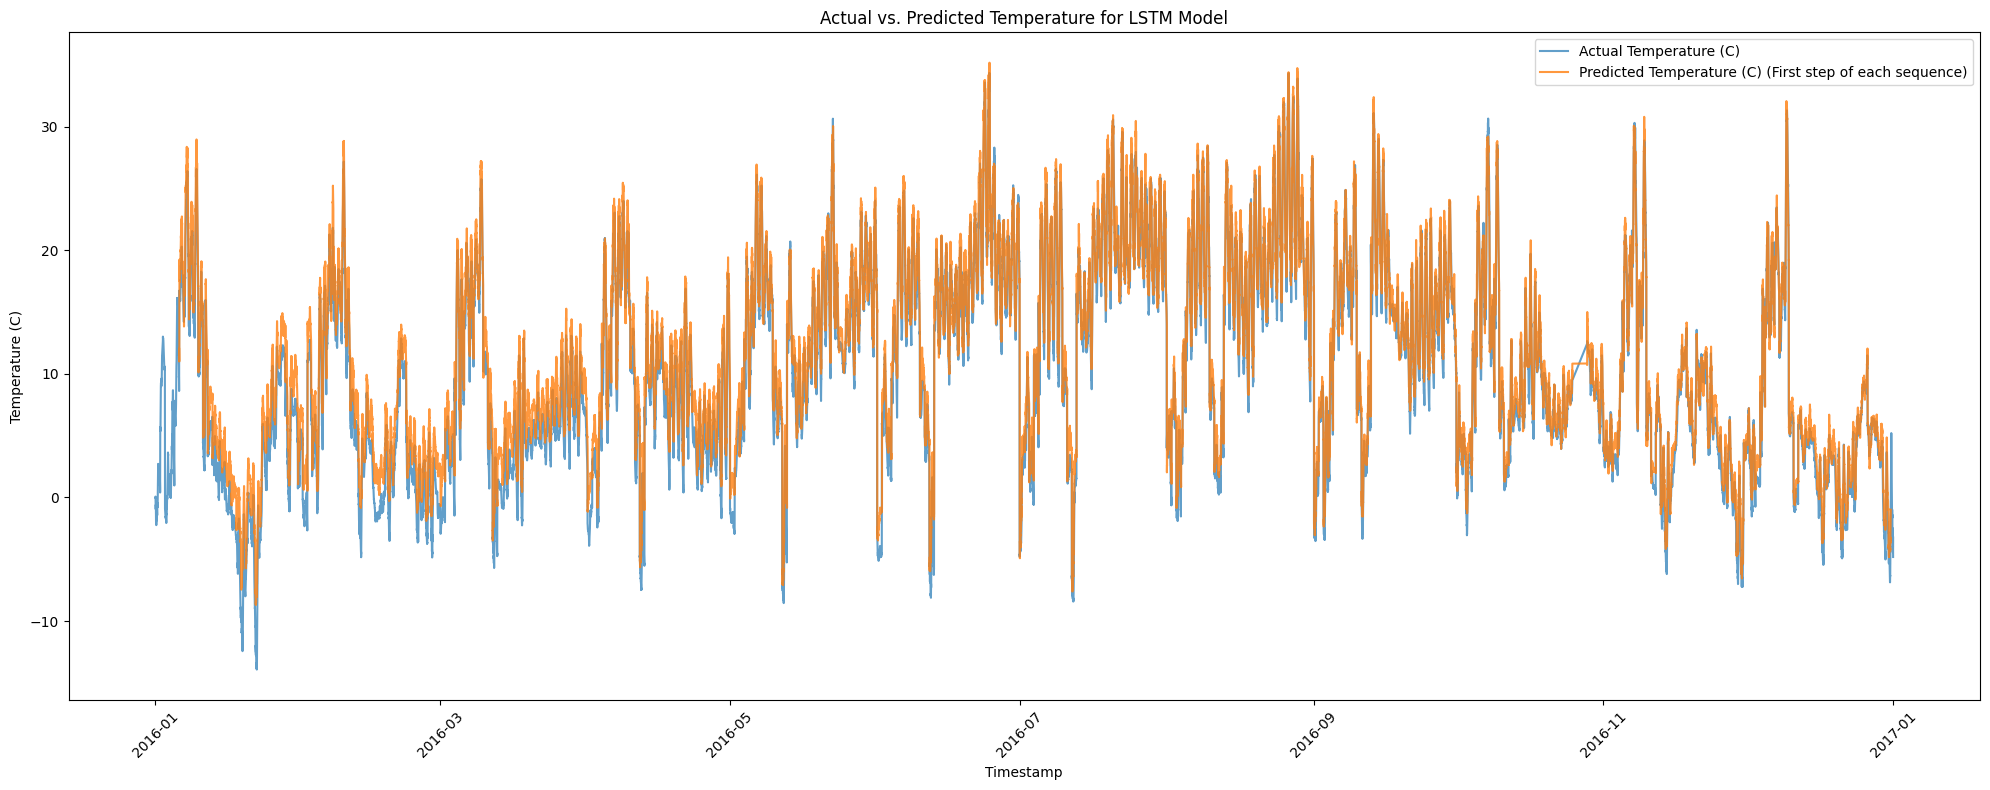

In [ ]:
temp_col_idx = valid_df.columns.get_loc("Temperature (C)")

actual_temp_scaled = val_data["Temperature (C)"].values
dummy_full_actual = np.zeros((len(actual_temp_scaled), scaler.n_features_in_))
dummy_full_actual[:, temp_col_idx] = actual_temp_scaled
actual_temp_original = scaler.inverse_transform(dummy_full_actual)[:, temp_col_idx]

predicted_temp_scaled_first_step = val_predictions[:, 0, 0]
dummy_predicted = np.zeros((len(predicted_temp_scaled_first_step), scaler.n_features_in_))
dummy_predicted[:, temp_col_idx] = predicted_temp_scaled_first_step
predicted_temp_original = scaler.inverse_transform(dummy_predicted)[:, temp_col_idx]

predicted_timestamps = valid_dt_ts.iloc[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

plt.figure(figsize=(20, 8))

# Plot full actual temperatures for the entire validation period
plt.plot(valid_dt_ts, actual_temp_original, label="Actual Temperature (C)", alpha=0.7)

# Overlay the continuous predicted temperatures. We need to match the time range.
# The predicted_temp_original corresponds to the timestamps in predicted_timestamps.
plt.plot(predicted_timestamps, predicted_temp_original, label="Predicted Temperature (C) (First step of each sequence)", alpha=0.8)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.title("Actual vs. Predicted Temperature for LSTM Model")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
actual_temp_for_rmse = actual_temp_original[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

print(f"RMSE for GRU Model- {rmse(actual_temp_for_rmse, predicted_temp_original)}")

RMSE for LSTM Model- 1.9463187985112393


Overall the first model we used is pretty good! There don't appear to be issues with overfitting, so if I look at additional models I may consider increasing the complexity such as increasing the number of layers.

# Analysis

### Compare with an LSTM model

I first decide to look at comparing the first model to the LSTM model of the same architecture.

In [50]:
# Use the past year worth of data (total raw timesteps for input)
past_raw_timesteps = 720
# To predict the next 12 hours (total raw timesteps for output)
future_raw_timesteps = 72
# Sampling rate for input sequence (e.g., take every 6th observation for input)
sampling_step_rate = 6

# Effective sequence length in terms of sampled points for the input
input_sequence_length_sampled = int(past_raw_timesteps / sampling_step_rate)

# Determine number of features for input and output
num_input_features = train_data.drop(columns=["Temperature (C)"]).shape[1] # 11 features after dropping target
num_output_features = 1 # We are predicting only Temperature (C)

# Identify input feature columns
input_feature_columns = [col for col in train_data.columns if col != "Temperature (C)"]

# Generate training sequences
X_train_seq, Y_train_seq = create_sequences(
    train_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

batch_size = 256

# Create tf.data.Dataset for training
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_seq, Y_train_seq))
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_train:", X_train_seq.shape)
print("Target sequence shape for dataset_train:", Y_train_seq.shape)

Input sequence shape for dataset_train: (367480, 120, 11)
Target sequence shape for dataset_train: (367480, 72, 1)


In [51]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
batch_size = 256 # Keep this consistent with dataset creation
epochs = 100

In [53]:
model = Sequential()
# Input shape for GRU: (sampled_sequence_length, num_input_features)
model.add(LSTM(units=50, activation='relu', input_shape=(input_sequence_length_sampled, num_input_features)))
# Repeats the last hidden state for the number of future raw timesteps to predict
model.add(RepeatVector(future_raw_timesteps))
# return_sequences=True for sequence output
model.add(LSTM(units=50, activation='relu', return_sequences=True))
# Predicts one feature (Temperature C) for each output timestep
model.add(TimeDistributed(Dense(units=num_output_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 72, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 72, 1)          │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,651 (127.54 KB)

 Trainable params: 32,651 (127.54 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# Pass the pre-made validation dataset to validation_data argument instead of using validation_split
model.fit(dataset_train, epochs=epochs, callbacks=[es_callback], validation_data=dataset_val)


Epoch 1/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - loss: 0.0199 - val_loss: 0.0060
Epoch 2/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 3/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 4/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 5/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 6/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 7/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 10/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 11/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0034 - val_loss: 0.00

0.003333793021738529


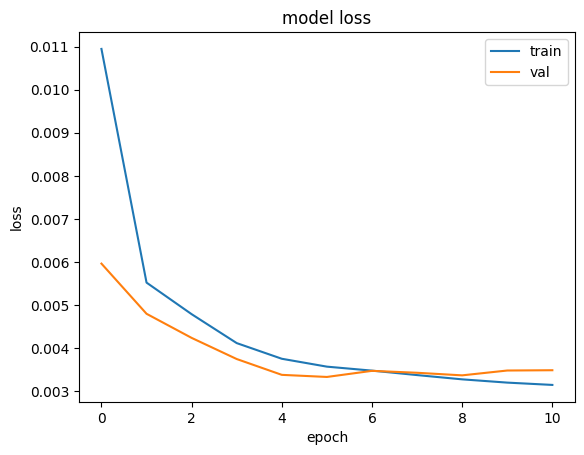

In [55]:
# plot validation loss vs loss
print(min(model.history.history['val_loss']))
plt.figure()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [56]:
model.save('/content/drive/MyDrive/Colab Notebooks/weather_lstm_model_1.keras')

In [57]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


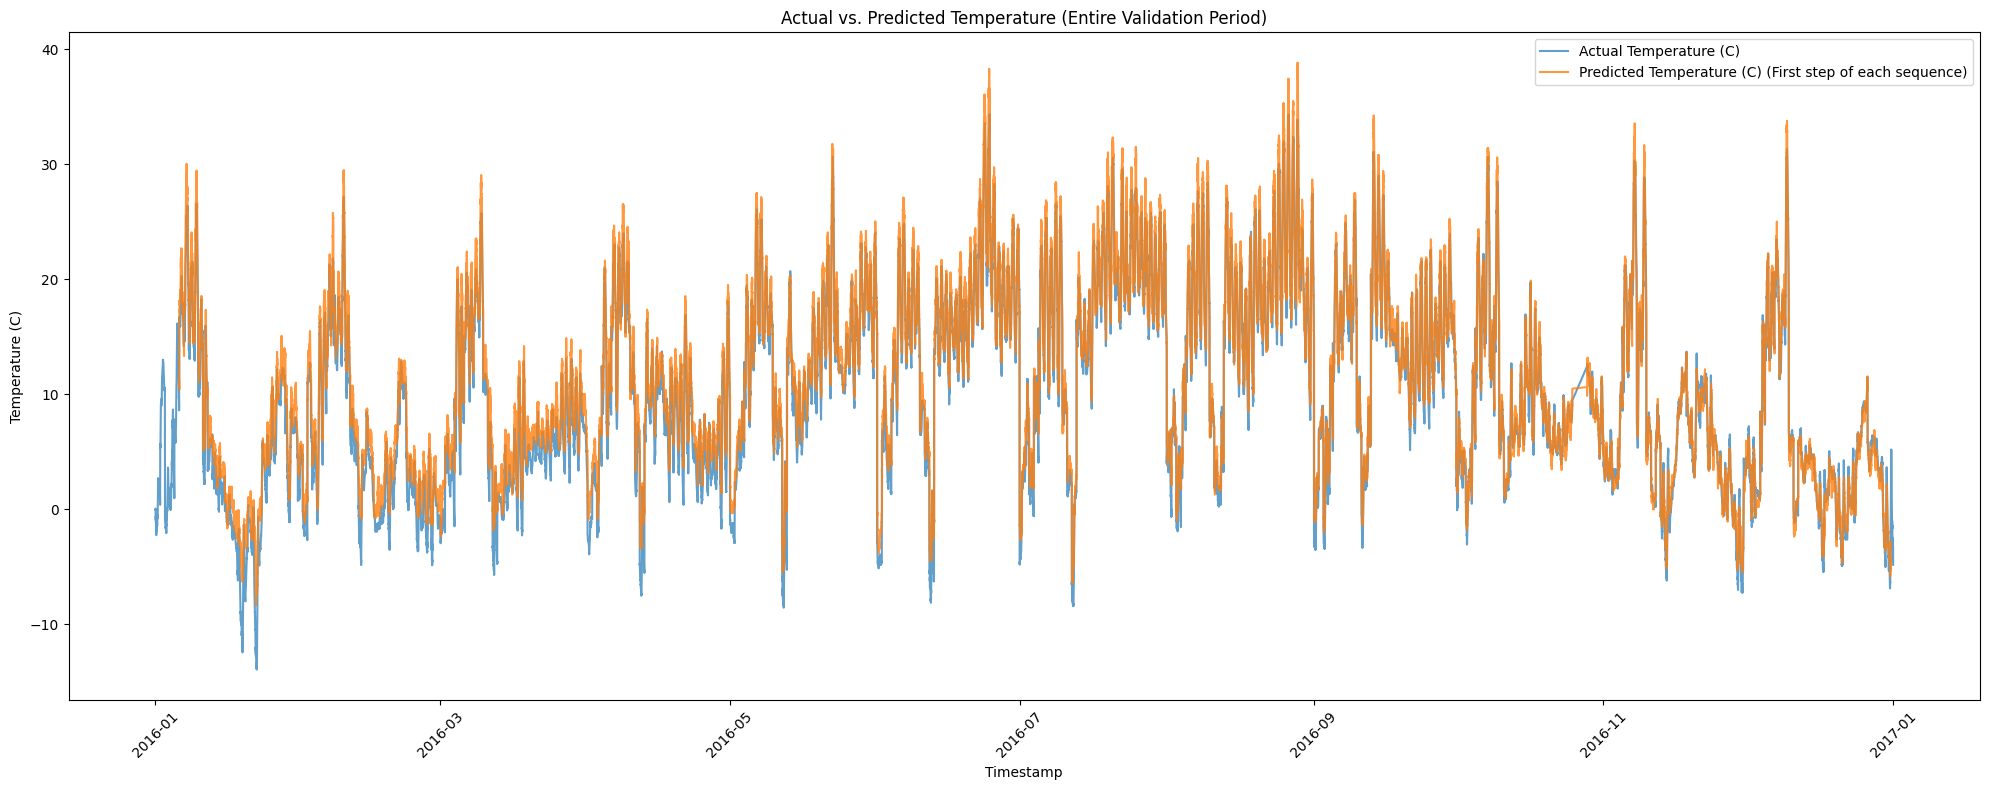

In [ ]:
temp_col_idx = valid_df.columns.get_loc("Temperature (C)")

actual_temp_scaled = val_data["Temperature (C)"].values
dummy_full_actual = np.zeros((len(actual_temp_scaled), scaler.n_features_in_))
dummy_full_actual[:, temp_col_idx] = actual_temp_scaled
actual_temp_original = scaler.inverse_transform(dummy_full_actual)[:, temp_col_idx]

predicted_temp_scaled_first_step = val_predictions[:, 0, 0]
dummy_predicted = np.zeros((len(predicted_temp_scaled_first_step), scaler.n_features_in_))
dummy_predicted[:, temp_col_idx] = predicted_temp_scaled_first_step
predicted_temp_original = scaler.inverse_transform(dummy_predicted)[:, temp_col_idx]

predicted_timestamps = valid_dt_ts.iloc[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

plt.figure(figsize=(20, 8))

# Plot full actual temperatures for the entire validation period
plt.plot(valid_dt_ts, actual_temp_original, label="Actual Temperature (C)", alpha=0.7)

plt.plot(predicted_timestamps, predicted_temp_original, label="Predicted Temperature (C) (First step of each sequence)", alpha=0.8)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.title("Actual vs. Predicted Temperature (Entire Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [59]:
actual_temp_for_rmse = actual_temp_original[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

print(f"RMSE for LSTM Model 1- {rmse(actual_temp_for_rmse, predicted_temp_original)}")


RMSE for LSTM Model 1- 1.8475905339362826


Overall the LSTM model with the same architecture is comparable. I choose to stick with using the GRU model for model optimization below only because it trains a little faster.

## Increase number of GRU units

Let's increase the model complexity, first by adding to the number of units in each GRU layer

In [ ]:
# Use the past year worth of data (total raw timesteps for input)
past_raw_timesteps = 720
# To predict the next 12 hours (total raw timesteps for output)
future_raw_timesteps = 72
# Sampling rate for input sequence (e.g., take every 6th observation for input)
sampling_step_rate = 6

# Effective sequence length in terms of sampled points for the input
input_sequence_length_sampled = int(past_raw_timesteps / sampling_step_rate)

# Determine number of features for input and output
num_input_features = train_data.drop(columns=["Temperature (C)"]).shape[1]
num_output_features = 1 # We are predicting only Temperature (C)

# Identify input feature columns
input_feature_columns = [col for col in train_data.columns if col != "Temperature (C)"]

# Generate training sequences
X_train_seq, Y_train_seq = create_sequences(
    train_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

batch_size = 256

# Create tf.data.Dataset for training
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_seq, Y_train_seq))
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_train:", X_train_seq.shape)
print("Target sequence shape for dataset_train:", Y_train_seq.shape)

Input sequence shape for dataset_train: (367480, 120, 11)
Target sequence shape for dataset_train: (367480, 72, 1)


In [14]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


In [13]:
model = Sequential()
# Input shape for GRU: (sampled_sequence_length, num_input_features)
model.add(GRU(units=100, activation='relu', input_shape=(input_sequence_length_sampled, num_input_features)))
# Repeats the last hidden state for the number of future raw timesteps to predict
model.add(RepeatVector(future_raw_timesteps))
# return_sequences=True for sequence output
model.add(GRU(units=100, activation='relu', return_sequences=True))
# Predicts one feature (Temperature C) for each output timestep
model.add(TimeDistributed(Dense(units=num_output_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100)            │        33,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 72, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 72, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 72, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,601 (369.54 KB)

 Trainable params: 94,601 (369.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# Pass the pre-made validation dataset to validation_data argument instead of using validation_split
model.fit(dataset_train, epochs=epochs, callbacks=[es_callback], validation_data=dataset_val)


Epoch 1/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - loss: 0.0174 - val_loss: 0.0081
Epoch 2/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 4/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 5/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 7/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 8/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 11/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 0.0034 - val_loss: 0.00

0.0027006028685718775


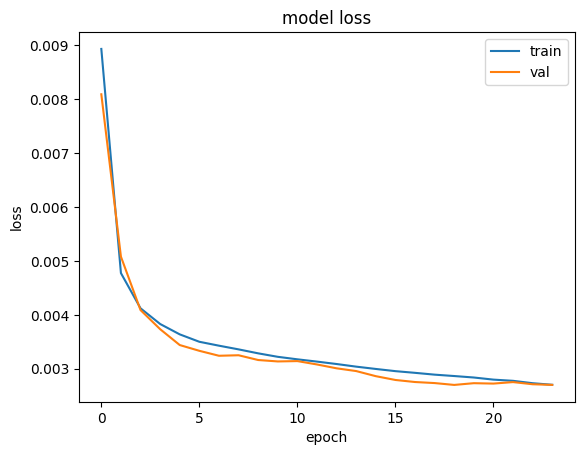

In [18]:
# plot validation loss vs loss
print(min(model.history.history['val_loss']))
plt.figure()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [19]:
model.save('/content/drive/MyDrive/Colab Notebooks/weather_gru_model_2.keras')


In [20]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


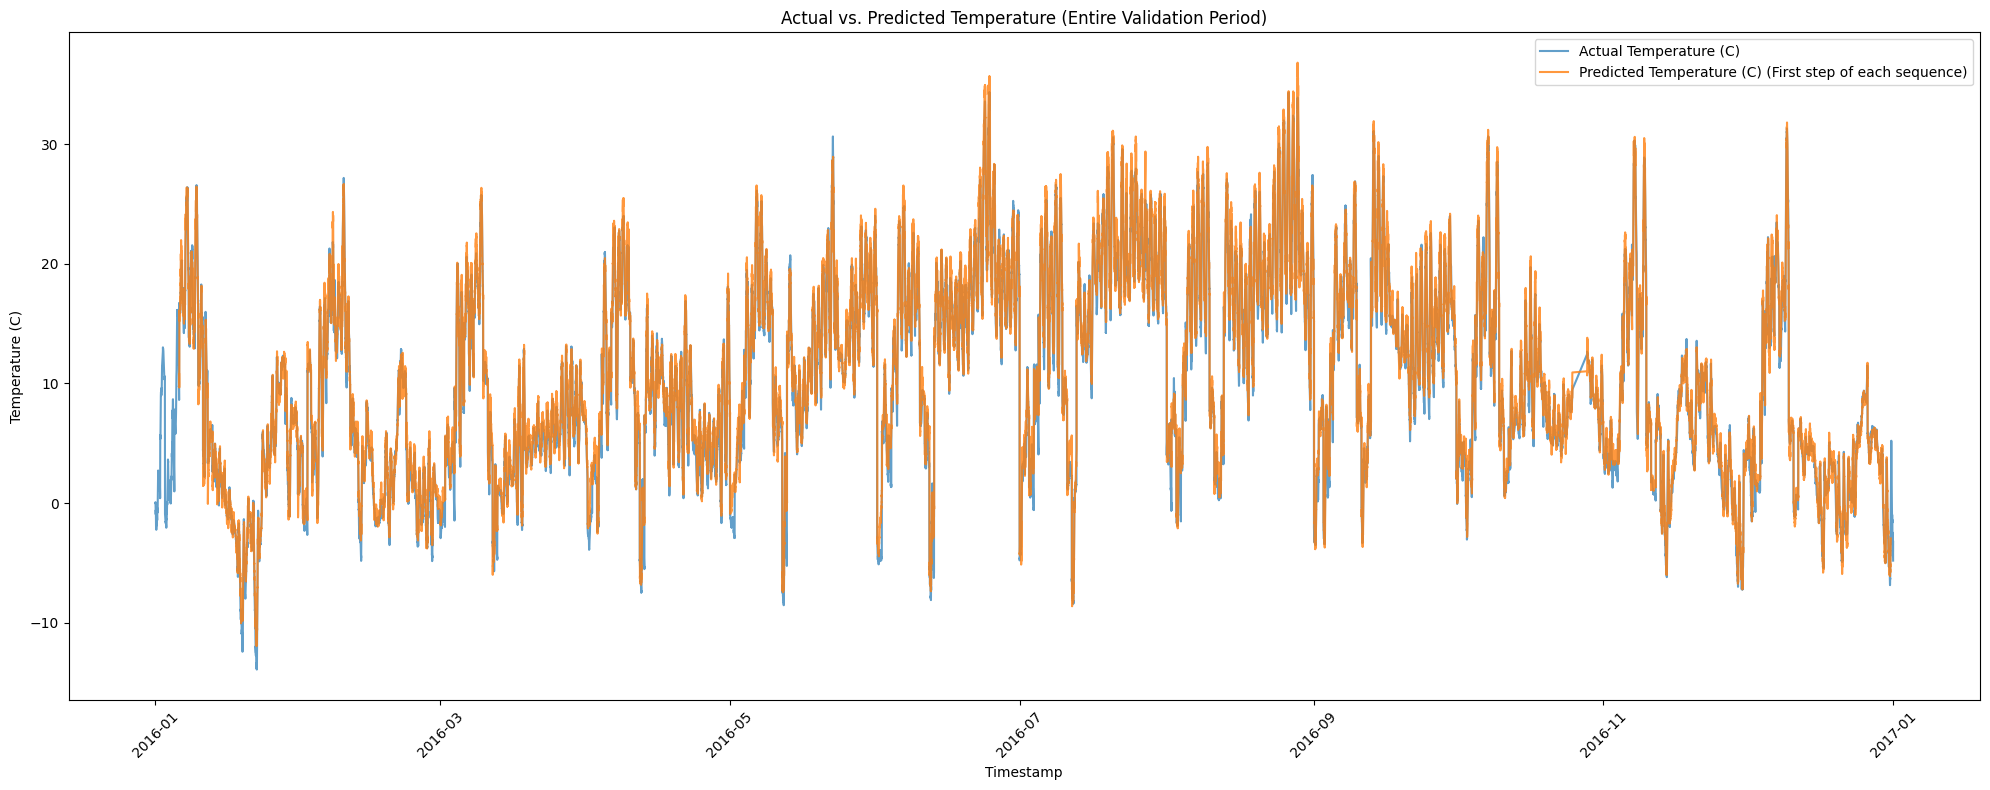

In [ ]:
temp_col_idx = valid_df.columns.get_loc("Temperature (C)")

actual_temp_scaled = val_data["Temperature (C)"].values
dummy_full_actual = np.zeros((len(actual_temp_scaled), scaler.n_features_in_))
dummy_full_actual[:, temp_col_idx] = actual_temp_scaled
actual_temp_original = scaler.inverse_transform(dummy_full_actual)[:, temp_col_idx]

predicted_temp_scaled_first_step = val_predictions[:, 0, 0]
dummy_predicted = np.zeros((len(predicted_temp_scaled_first_step), scaler.n_features_in_))
dummy_predicted[:, temp_col_idx] = predicted_temp_scaled_first_step
predicted_temp_original = scaler.inverse_transform(dummy_predicted)[:, temp_col_idx]

predicted_timestamps = valid_dt_ts.iloc[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

plt.figure(figsize=(20, 8))

# Plot full actual temperatures for the entire validation period
plt.plot(valid_dt_ts, actual_temp_original, label="Actual Temperature (C)", alpha=0.7)

# Overlay the continuous predicted temperatures. We need to match the time range.
# The predicted_temp_original corresponds to the timestamps in predicted_timestamps.
plt.plot(predicted_timestamps, predicted_temp_original, label="Predicted Temperature (C) (First step of each sequence)", alpha=0.8)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.title("Actual vs. Predicted Temperature (Entire Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
actual_temp_for_rmse = actual_temp_original[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

print(f"RMSE for GRU Model 2- {rmse(actual_temp_for_rmse, predicted_temp_original)}")


RMSE for GRU Model 2- 1.406596327385195


This second GRU model is substantially better than the previous two models, both from an RMSE and validation loss perspective. Given that we're still not seeing issues with overfitting, let's see if we see any improvement by doubling the number of GRU layers.


## Increase the Number of GRU Layers

Because we still don't seem to have an issue with overfitting when increasing the number of units in each GRU layer by 2x, we decide to see if adding an additional GRU layer (from 2 -> 4) will increase accuracy without risking overfitting.

In [23]:
# Use the past year worth of data (total raw timesteps for input)
past_raw_timesteps = 720
# To predict the next 12 hours (total raw timesteps for output)
future_raw_timesteps = 72
# Sampling rate for input sequence (e.g., take every 6th observation for input)
sampling_step_rate = 6

# Effective sequence length in terms of sampled points for the input
input_sequence_length_sampled = int(past_raw_timesteps / sampling_step_rate)

# Determine number of features for input and output
num_input_features = train_data.drop(columns=["Temperature (C)"]).shape[1] # 11 features after dropping target
num_output_features = 1 # We are predicting only Temperature (C)

# Identify input feature columns
input_feature_columns = [col for col in train_data.columns if col != "Temperature (C)"]

# Generate training sequences
X_train_seq, Y_train_seq = create_sequences(
    train_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

batch_size = 256

# Create tf.data.Dataset for training
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_seq, Y_train_seq))
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_train:", X_train_seq.shape)
print("Target sequence shape for dataset_train:", Y_train_seq.shape)

Input sequence shape for dataset_train: (367480, 120, 11)
Target sequence shape for dataset_train: (367480, 72, 1)


In [24]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [28]:
model = Sequential()
# Input shape for GRU: (sampled_sequence_length, num_input_features)
model.add(GRU(units=100, activation='relu', input_shape=(input_sequence_length_sampled, num_input_features)))
# Repeats the last hidden state for the number of future raw timesteps to predict
model.add(RepeatVector(future_raw_timesteps))
# return_sequences=True for sequence output
model.add(GRU(units=100, activation='relu', return_sequences=True))
# return_sequences=True for sequence output
model.add(GRU(units=100, activation='relu', return_sequences=True))
# return_sequences=True for sequence output
model.add(GRU(units=100, activation='relu', return_sequences=True))
# Predicts one feature (Temperature C) for each output timestep
model.add(TimeDistributed(Dense(units=num_output_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 100)            │        33,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 72, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 72, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 72, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 72, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 72, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,801 (842.97 KB)

 Trainable params: 215,801 (842.97 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

# Pass the pre-made validation dataset to validation_data argument instead of using validation_split
model.fit(dataset_train, epochs=epochs, callbacks=[es_callback], validation_data=dataset_val)


Epoch 1/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - loss: 0.0206 - val_loss: 0.0050
Epoch 2/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 3/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 4/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 5/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 6/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 7/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 8/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 10/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0034 - val_loss: 0.00

0.002921722363680601


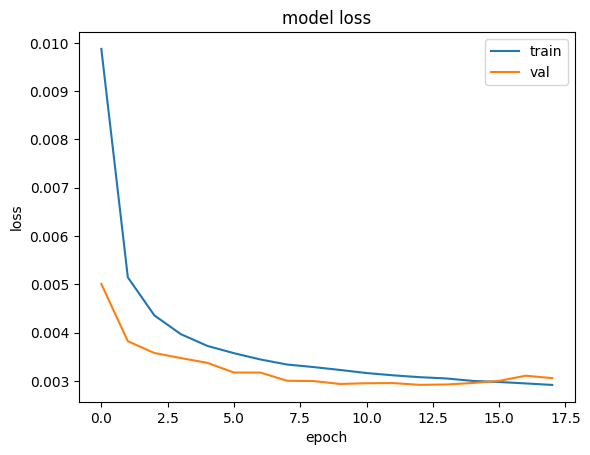

In [30]:
# plot validation loss vs loss
print(min(model.history.history['val_loss']))
plt.figure()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [31]:
model.save('/content/drive/MyDrive/Colab Notebooks/weather_gru_model_3.keras')


In [32]:
# Generate validation sequences
X_val_seq, Y_val_seq = create_sequences(
    val_data,
    input_sequence_length_sampled,
    future_raw_timesteps,
    sampling_step_rate,
    input_feature_columns,
    "Temperature (C)"
)

# Create tf.data.Dataset for validation
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_seq, Y_val_seq))
dataset_val = dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Input sequence shape for dataset_val:", X_val_seq.shape)
print("Target sequence shape for dataset_val:", Y_val_seq.shape)

# Make predictions on the validation data
val_predictions = model.predict(dataset_val)


Input sequence shape for dataset_val: (51469, 120, 11)
Target sequence shape for dataset_val: (51469, 72, 1)
202/202 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


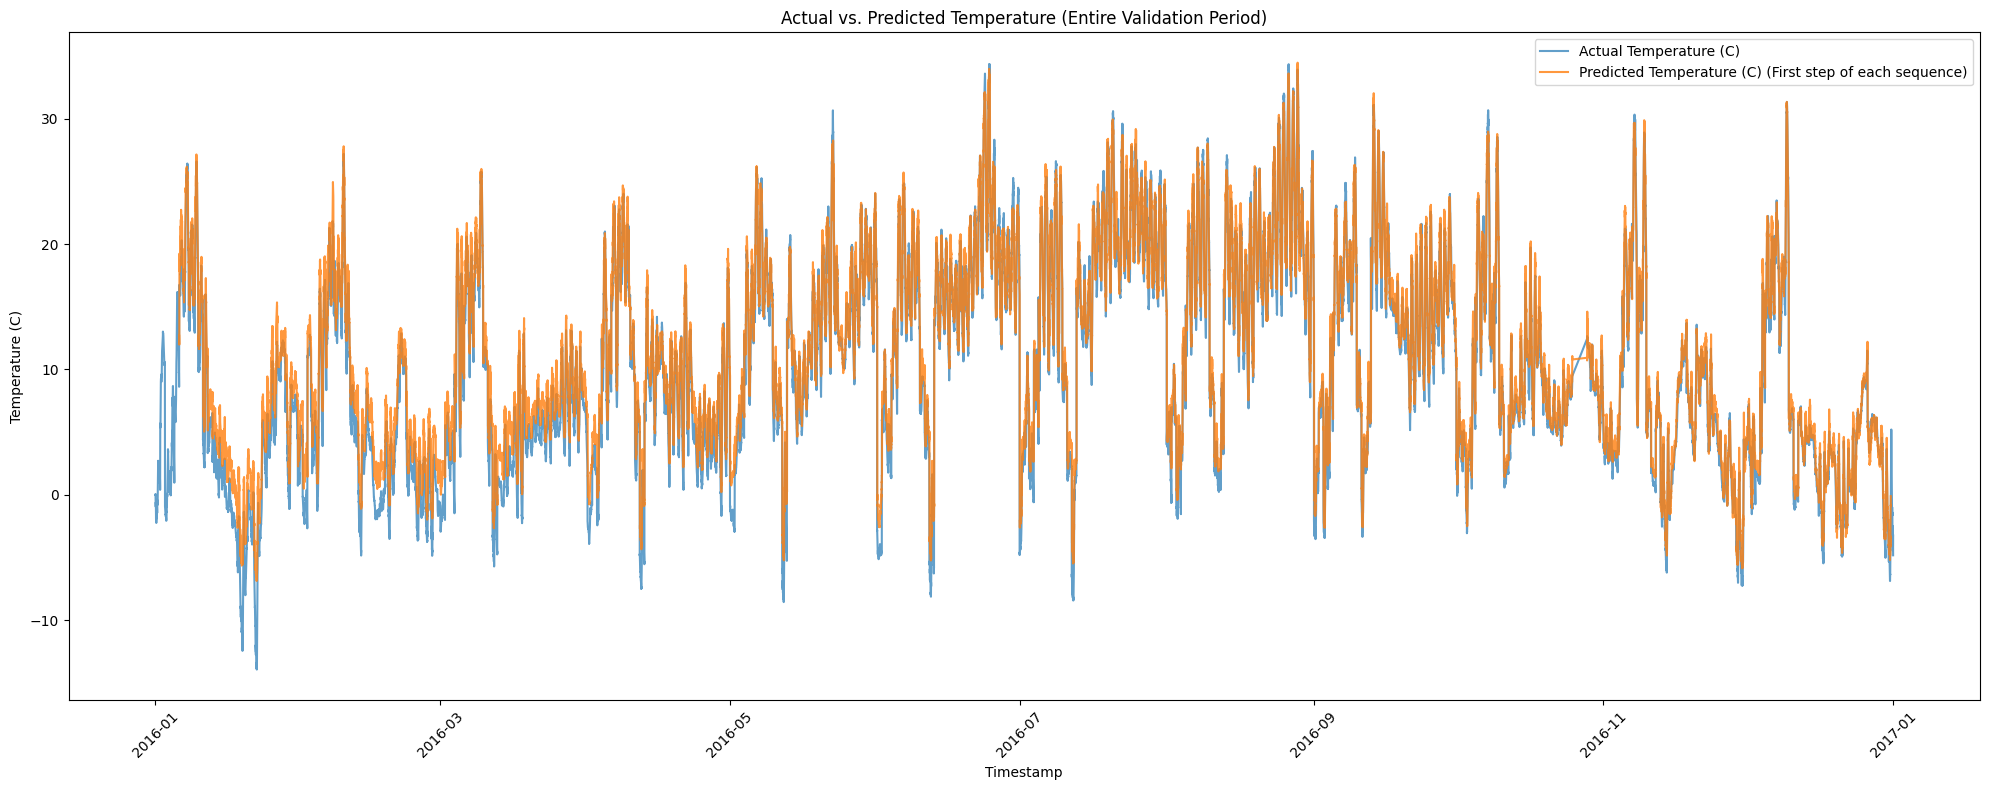

In [ ]:
temp_col_idx = valid_df.columns.get_loc("Temperature (C)")

actual_temp_scaled = val_data["Temperature (C)"].values
dummy_full_actual = np.zeros((len(actual_temp_scaled), scaler.n_features_in_))
dummy_full_actual[:, temp_col_idx] = actual_temp_scaled
actual_temp_original = scaler.inverse_transform(dummy_full_actual)[:, temp_col_idx]

predicted_temp_scaled_first_step = val_predictions[:, 0, 0] # Take the first predicted point (next 10-min) from each sequence
dummy_predicted = np.zeros((len(predicted_temp_scaled_first_step), scaler.n_features_in_))
dummy_predicted[:, temp_col_idx] = predicted_temp_scaled_first_step
predicted_temp_original = scaler.inverse_transform(dummy_predicted)[:, temp_col_idx]

predicted_timestamps = valid_dt_ts.iloc[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

plt.figure(figsize=(20, 8))

# Plot full actual temperatures for the entire validation period
plt.plot(valid_dt_ts, actual_temp_original, label="Actual Temperature (C)", alpha=0.7)

# Overlay the continuous predicted temperatures. We need to match the time range.
# The predicted_temp_original corresponds to the timestamps in predicted_timestamps.
plt.plot(predicted_timestamps, predicted_temp_original, label="Predicted Temperature (C) (First step of each sequence)", alpha=0.8)

plt.xlabel("Timestamp")
plt.ylabel("Temperature (C)")
plt.title("Actual vs. Predicted Temperature (Entire Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
actual_temp_for_rmse = actual_temp_original[past_raw_timesteps : past_raw_timesteps + len(predicted_temp_original)]

print(f"RMSE for GRU Model 3- {rmse(actual_temp_for_rmse, predicted_temp_original)}")


RMSE for GRU Model 3- 1.8682641734449685


Doubling the number of GRU layers didn't improve the performance despite the increased model complexity, so it appears the 2-layer GRU model was favorable to the 4-layer GRU model for this dataset.

# Results

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

For this problem unlike a lot of my other AI models, I didn't have issues with overfitting- so when I looked to try different models I tried different variations of more complex models.

None of the models I tried had issues with overfitting, but in certain cases such as increasing the layers the increase complexity did not help with the accuracy.

Overall, increasing the number of units in each GRU layer had the most beneficial improvements on performance, so if I had more time to optimize I'd look to continue trying to tweak the number of units.

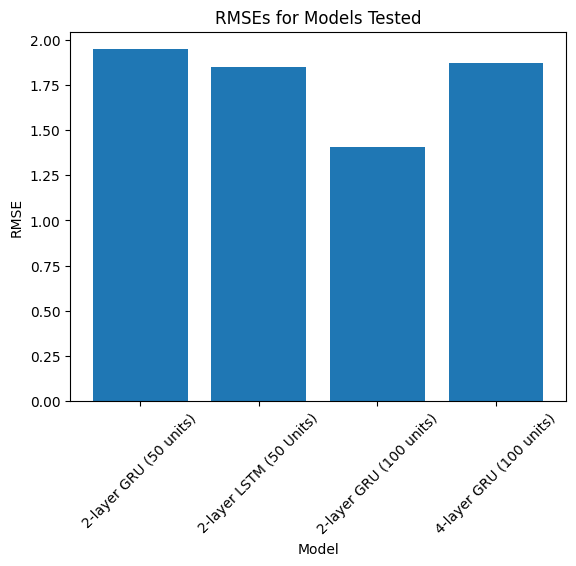

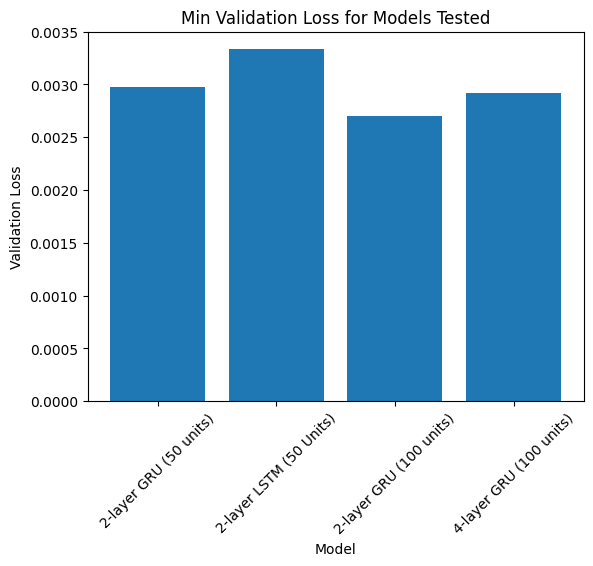

In [36]:
models = ["2-layer GRU (50 units)", "2-layer LSTM (50 Units)", "2-layer GRU (100 units)", "4-layer GRU (100 units)"]
rmses = [1.9463188, 1.84759053, 1.40659633, 1.86826417]
min_val_loss = [.00297137, .00333379, .0027006, .00292172]

plt.figure()
plt.bar(models, rmses)
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSEs for Models Tested")
plt.xticks(rotation = 45)
plt.show()

plt.figure()
plt.bar(models, min_val_loss)
plt.xlabel("Model")
plt.ylabel("Validation Loss")
plt.title("Min Validation Loss for Models Tested")
plt.xticks(rotation = 45)
plt.show()


# Conclusion

Overall RNNs did very well when applied to time series forecasting. It introduced an interesting concept of training on all historical data, but only using subsets of historical data to forecast a small window into the future, which I think could be very powerful. If I had time to work on this more, here are some of the things I might have looked into:
* Modify past timestamps used for predicted and amount of future timestamps predicted to see how that affects the score
* Further tune the number of GRU layers, the units in each layer, etc. Based on the models I tried, I'd start with further increasing the units in each layer.
* See how much the performance would suffer if the model needed to predict all of 2016 without any data, by creating rolling predictions and then using those predictions as the input for the next prediction. This would have given me some insight into how accurate RNNs are at long term forecasting.



# References

* https://www.kaggle.com/code/raminhuseyn/time-series-forecasting-exploratory-data-analysis
* https://keras.io/examples/timeseries/timeseries_weather_forecasting/
* https://keras.io/examples/timeseries/timeseries_traffic_forecasting/
